In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

In [3]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

# Read the CSV and Perform Basic Data Cleaning

In [4]:
# https://help.lendingclub.com/hc/en-us/articles/215488038-What-do-the-different-Note-statuses-mean-

columns = [
    "loan_amnt", "int_rate", "installment", "home_ownership",
    "annual_inc", "verification_status", "issue_d", "loan_status",
    "pymnt_plan", "dti", "delinq_2yrs", "inq_last_6mths",
    "open_acc", "pub_rec", "revol_bal", "total_acc",
    "initial_list_status", "out_prncp", "out_prncp_inv", "total_pymnt",
    "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee",
    "recoveries", "collection_recovery_fee", "last_pymnt_amnt", "next_pymnt_d",
    "collections_12_mths_ex_med", "policy_code", "application_type", "acc_now_delinq",
    "tot_coll_amt", "tot_cur_bal", "open_acc_6m", "open_act_il",
    "open_il_12m", "open_il_24m", "mths_since_rcnt_il", "total_bal_il",
    "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc",
    "all_util", "total_rev_hi_lim", "inq_fi", "total_cu_tl",
    "inq_last_12m", "acc_open_past_24mths", "avg_cur_bal", "bc_open_to_buy",
    "bc_util", "chargeoff_within_12_mths", "delinq_amnt", "mo_sin_old_il_acct",
    "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op", "mo_sin_rcnt_tl", "mort_acc",
    "mths_since_recent_bc", "mths_since_recent_inq", "num_accts_ever_120_pd", "num_actv_bc_tl",
    "num_actv_rev_tl", "num_bc_sats", "num_bc_tl", "num_il_tl",
    "num_op_rev_tl", "num_rev_accts", "num_rev_tl_bal_gt_0",
    "num_sats", "num_tl_120dpd_2m", "num_tl_30dpd", "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m", "pct_tl_nvr_dlq", "percent_bc_gt_75", "pub_rec_bankruptcies",
    "tax_liens", "tot_hi_cred_lim", "total_bal_ex_mort", "total_bc_limit",
    "total_il_high_credit_limit", "hardship_flag", "debt_settlement_flag"
]

target = ["loan_status"]

In [5]:
# Load the data
file_path = Path('LoanStats_2019Q1.csv')
df = pd.read_csv(file_path, skiprows=1)[:-2]
df = df.loc[:, columns].copy()

# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')

# Drop the null rows
df = df.dropna()

# Remove the `Issued` loan status
issued_mask = df['loan_status'] != 'Issued'
df = df.loc[issued_mask]

# convert interest rate to numerical
df['int_rate'] = df['int_rate'].str.replace('%', '')
df['int_rate'] = df['int_rate'].astype('float') / 100


# Convert the target column values to low_risk and high_risk based on their values
x = {'Current': 'low_risk'}   
df = df.replace(x)

x = dict.fromkeys(['Late (31-120 days)', 'Late (16-30 days)', 'Default', 'In Grace Period'], 'high_risk')    
df = df.replace(x)

df.reset_index(inplace=True, drop=True)

df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


# Split the Data into Training and Testing

In [6]:
# Create our features
X = df.copy()
X = X.drop("loan_status", axis=1)
X = pd.get_dummies(X)
#X.head()

# Create our target low_risk=1, high_risk=0
y = df["loan_status"].values
y = pd.get_dummies(y)
y["loan_status"] = y["low_risk"]
y = y.drop(["high_risk", "low_risk"], axis=1)
y.dtypes

loan_status    uint8
dtype: object

In [7]:
#X.describe()
#X.dtypes
X.head()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,issue_d_Mar-2019,pymnt_plan_n,initial_list_status_f,initial_list_status_w,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,application_type_Individual,application_type_Joint App,hardship_flag_N,debt_settlement_flag_N
0,10500.0,0.1719,375.35,66000.0,27.24,0.0,0.0,8.0,0.0,1609.0,...,1,1,0,1,0,1,1,0,1,1
1,25000.0,0.2000,929.09,105000.0,20.23,0.0,0.0,17.0,1.0,18368.0,...,1,1,0,1,0,1,1,0,1,1
2,20000.0,0.2000,529.88,56000.0,24.26,0.0,0.0,8.0,0.0,13247.0,...,1,1,0,1,0,1,1,0,1,1
3,10000.0,0.1640,353.55,92000.0,31.44,0.0,1.0,10.0,1.0,17996.0,...,1,1,0,1,0,1,1,0,1,1
4,22000.0,0.1474,520.39,52000.0,18.76,0.0,1.0,14.0,0.0,9091.0,...,1,1,0,1,0,1,1,0,1,1


In [8]:
# Check the balance of our target values
y['loan_status'].value_counts()

1    68470
0      347
Name: loan_status, dtype: int64

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler

X, y = make_classification(random_state=42, n_features=20, n_informative=5, n_redundant=0, n_samples=1000)
X = pd.DataFrame(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Ensemble Learners

In this section, you will compare two ensemble algorithms to determine which algorithm results in the best performance. You will train a Balanced Random Forest Classifier and an Easy Ensemble AdaBoost classifier . For each algorithm, be sure to complete the folliowing steps:

1. Train the model using the training data. 
2. Calculate the balanced accuracy score from sklearn.metrics.
3. Print the confusion matrix from sklearn.metrics.
4. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.
5. For the Balanced Random Forest Classifier onely, print the feature importance sorted in descending order (most important feature to least important) along with the feature score

Note: Use a random state of 1 for each algorithm to ensure consistency between tests

### Balanced Random Forest Classifier

In [35]:
# Resample the training data with the BalancedRandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

X_train_scaled, y_train_scaled = make_classification(n_samples=1000, n_classes=2, random_state=1)
clf = BalancedRandomForestClassifier(random_state=1)
clf.fit(X_train_scaled, y_train_scaled)  

y_pred = clf.predict(X_test_scaled)



In [36]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_test, y_pred)

0.36198066705076504

In [37]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[62, 65],
       [94, 29]])

In [38]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.40      0.49      0.24      0.44      0.34      0.12       127
          1       0.31      0.24      0.49      0.27      0.34      0.11       123

avg / total       0.35      0.36      0.36      0.35      0.34      0.12       250



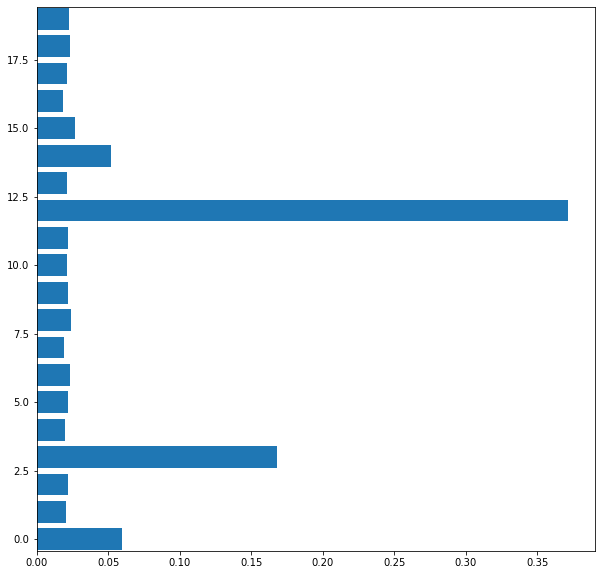

In [39]:
# List the features sorted in descending order by feature importance
%matplotlib inline
from matplotlib import pyplot as plt
feature_importances = clf.feature_importances_
features = sorted(zip(X.columns, clf.feature_importances_), key = lambda x: x[1])
cols = [f[0] for f in features]
width = [f[1] for f in features]

fig, ax = plt.subplots()

fig.set_size_inches(10,10)
plt.margins(y=0.001)

ax.barh(y=cols, width=width)

plt.show()

### Easy Ensemble AdaBoost Classifier

In [40]:
# Train the EasyEnsembleClassifier
from imblearn.ensemble import EasyEnsembleClassifier 
clf = EasyEnsembleClassifier(n_estimators=100, random_state=1).fit(X_train, y_train)
y_pred = clf.predict(X_test)
#print(classification_report(y_test, y_pred, target_names=target_names))
print(f'Training Score: {clf.score(X_train, y_train)}')
print(f'Testing Score: {clf.score(X_test, y_test)}')

Training Score: 0.9373333333333334
Testing Score: 0.832


In [41]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_test, y_pred)

0.8319569809871327

In [42]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix
y_pred = clf.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[106,  21],
       [ 21, 102]])

In [43]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.83      0.83      0.83      0.83      0.83      0.69       127
          1       0.83      0.83      0.83      0.83      0.83      0.69       123

avg / total       0.83      0.83      0.83      0.83      0.83      0.69       250

